# SOLUTION Wk18 Lecture02 CodeAlong: UFOs

## Learning Objectives

- By the end of this CodeAlong, students will be able to:
   - Calculate time series statistics (rolling mean/std/diff/pct_change
   - Perform feature engineering for time series EDA 
   - Aggregate time series using date parts to answer stakeholder questions.

    

# 🕹️Part 1) Preparing Irregular-Interval Time Series

### Overview from Last Lecture

- 1) [ ] Convert the dates & times to a single column (if needed).
- 2) [ ] Convert the datetime column  (most likely a string) to a datetime data type.
- 3) [ ] Set the datetime column as the Series/DataFrame index
- 4) [ ] Resample the time series to the desired/correct frequency using the desired/correct aggregation method.
- 5) [ ] Impute null values (if required)


### UFO Sightings

- UFO Sightings: https://www.kaggle.com/datasets/NUFORC/ufo-sightings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
ufo  = pd.read_csv("../Data/ufos-kaggle/scrubbed.csv", low_memory=False)
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556


In [3]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


>- 1) [x] Convert the dates & times to a single column (if needed).

## Preparing the Datetime Index

## 1. All Dates and Times in One Row:

This is already true here; nothing to change.

## 2. Converting Date Cols to Datetime

In [4]:
## Investigate the date format
ufo.loc[0,'datetime']

'10/10/1949 20:30'

In [5]:
## Set the date format
fmt = '%m/%d/%Y %H:%M'

In [6]:
## convert datetime to datetime
ufo['datetime'] = pd.to_datetime(ufo['datetime'], format=fmt)

ValueError: time data '10/11/2006 24:00' does not match format '%m/%d/%Y %H:%M' (match)

### Handling Errors with pd.to_datetime

- Can use the `errors` argument for pd.to_datetime:
    - "raise" (default): raise an exception when errors happen
    - 'ignore': ignores the errors and returns the original value for that row. 
        - NOT RECOMMENDED: the entire column will not be datetime.
    - 'coerce': convert any bad datetime values to null values (NaT - NotATime)

>- **Branch point: we have a choice on how we deal with the bad timestamps.**
    -  Do we coerce them, make then null values, and drop them? Potentially losing a lot of data.
    - Or do we investigate a bit more to see if we can fix the problem without losing data.
    
    
- Let's see how much data we would lose if we chose to coerce the bad values:

In [7]:
##check nulls before coercing errors
ufo.isna().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [8]:
## Check missing data after coerce
coerced_dt = pd.to_datetime(ufo["datetime"], format=fmt, errors='coerce')
coerced_dt.isna().sum() / len(ufo)

0.008639147537718469

Should we drop the rows, or try to fix the times?

In [9]:
## Drop the rows
# ufo['datetime'] = pd.to_datetime(ufo["datetime"], format=fmt, errors='coerce')
# ufo = ufo.dropna(subset='datetime')

In [10]:
## Fix the errors: 
ufo['datetime'] = ufo['datetime'].str.replace('24:00', '23:59')
ufo['datetime'] = pd.to_datetime(ufo["datetime"], format=fmt)
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              80332 non-null  datetime64[ns]
 1   city                  80332 non-null  object        
 2   state                 74535 non-null  object        
 3   country               70662 non-null  object        
 4   shape                 78400 non-null  object        
 5   duration (seconds)    80332 non-null  object        
 6   duration (hours/min)  80332 non-null  object        
 7   comments              80317 non-null  object        
 8   date posted           80332 non-null  object        
 9   latitude              80332 non-null  float64       
 10  longitude             80332 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 6.7+ MB


> 🤔"`ParserError: hour must be in 0..23: 10/11/2006 24:00 present at position 0`"

## 3. Setting datetime index

In [11]:
ufo_ts = ufo.set_index('datetime')
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444


In [12]:
# check the index to confirm its datetime
ufo_ts.index

DatetimeIndex(['1949-10-10 20:30:00', '1949-10-10 21:00:00',
               '1955-10-10 17:00:00', '1956-10-10 21:00:00',
               '1960-10-10 20:00:00', '1961-10-10 19:00:00',
               '1965-10-10 21:00:00', '1965-10-10 23:45:00',
               '1966-10-10 20:00:00', '1966-10-10 21:00:00',
               ...
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:15:00',
               '2013-09-09 22:00:00', '2013-09-09 22:00:00',
               '2013-09-09 22:20:00', '2013-09-09 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=80332, freq=None)

- 3) [x] Set the datetime column as the Series/DataFrame index

## 4. Resampling

What frequency should we use?

### Let's Visualize Our Data

<Axes: xlabel='datetime'>

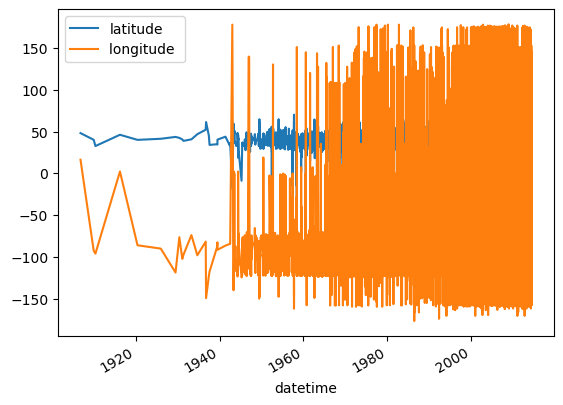

In [13]:
ufo_ts.plot()

> Hmmmm.... what are we *trying* to visualize?



### What do we really want to know about UFO's? 
- Duration of sighting?
- Location of sighting?
- Number of sightings?

## Timeseries of Number of Sightings

- We want to quantify the number of events that occurred within each interval.


In [14]:
## A.1) Add a count column with a value of 1 for each row and then use reasmple().sum()
ts = ufo_ts.resample('D').size()
ts.head()

datetime
1906-11-11    1
1906-11-12    0
1906-11-13    0
1906-11-14    0
1906-11-15    0
Freq: D, dtype: int64

<Axes: xlabel='datetime'>

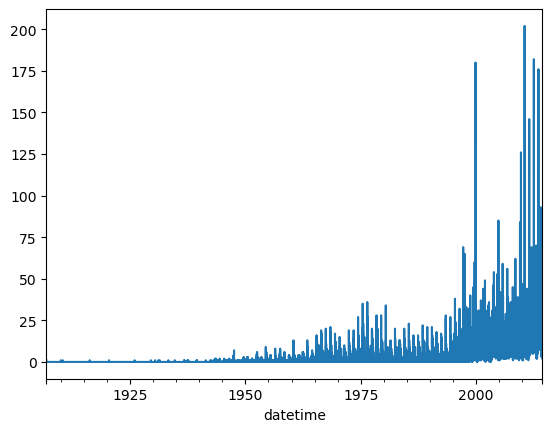

In [15]:
ts.plot()

In [16]:
## Change figsize
plt.rcParams['figure.figsize'] = [10,5]

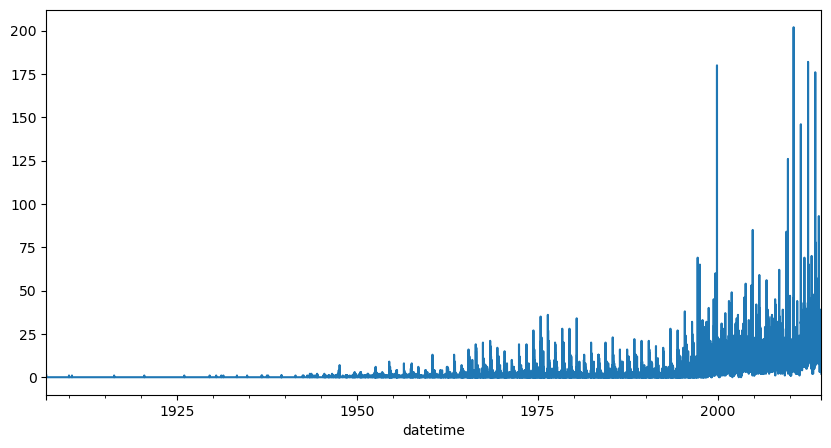

In [17]:
## Plot again
ts.plot();

> Let's keep data from 1950 to present day

In [18]:
ts = ts.loc["1950":]
ts

datetime
1950-01-01     0
1950-01-02     1
1950-01-03     0
1950-01-04     0
1950-01-05     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 23504, dtype: int64

<Axes: xlabel='datetime'>

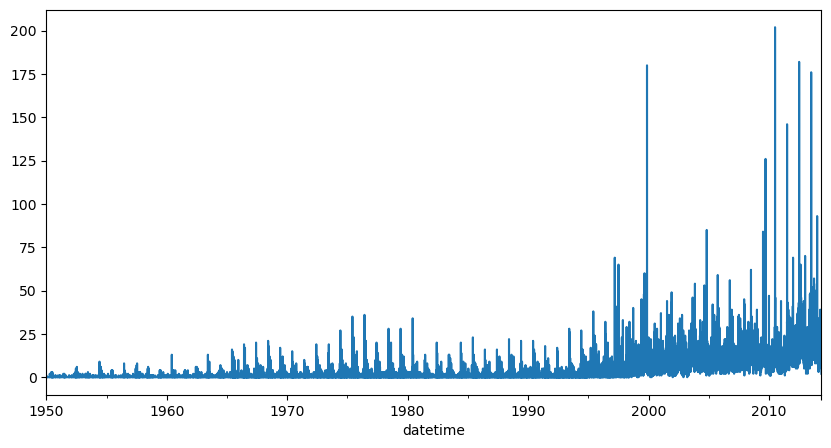

In [19]:
ts.plot()

# 🕹️Part 2) Aggregating Full Dataset Using Date Parts

## 📝 **Stakeholder Questions to Answer**

**ANSWER TOGETHER:**
- 1) What Month/Year had the most sightings? (and how many sightings were there?)

- 2) Which month of the year has the highest number of reported sightings?
- 3) Is there a seasonal pattern to UFO sightings? If so, how long is the season?

- 4) Which US holiday has the largest number of sightings?
___
**ANSWER SELECTED Q's IN BREAKOUT ROOMS**

- 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

- 6) What day of the week has the highest reported sightings?

- 7) At what time of day (hour) do most sightings occur?

- 8) Which US state has the most sightings?

- 9) Which country had the largest proportion of sightings for the year 2000?

- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes

### Making `eda_df` for answering questions

In [20]:
## making eda_df with date as a column instead of index
eda_df = ufo_ts.reset_index()
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556


### Feature Engineering: Date Parts

- Datetime objects have:
    - year
    - month
    - month_name()
    - day
    - day_name()
    - hour
    - seconds
    
- Pandas has a `.dt.` accessor to use datetime methods on an entire column at once.

In [21]:
## feature engineering for dates
eda_df['year'] = eda_df['datetime'].dt.year
eda_df['month'] = eda_df['datetime'].dt.month_name()
eda_df['day of month'] = eda_df['datetime'].dt.day
eda_df['day of week'] = eda_df['datetime'].dt.day_name()
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,October,10,Monday,20
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949,October,10,Monday,21
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955,October,10,Monday,17
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,October,10,Wednesday,21
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,October,10,Monday,20


> Let's add a "weekend" feature that will be True if the day was a Saturday or Sunday.

In [22]:
## let's add a weekend feature
eda_df['weekend'] = eda_df['day of week'].isin(['Saturday','Sunday'])
eda_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,October,10,Monday,20,False
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949,October,10,Monday,21,False
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955,October,10,Monday,17,False
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,October,10,Wednesday,21,False
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,October,10,Monday,20,False


#### Let's add a column for the decade

In [23]:
## Calculate decade by subtracting the remainder and div by 10
eda_df['decade'] = eda_df['year'] - eda_df['year'] % 10
eda_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend,decade
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,October,10,Monday,20,False,1940
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949,October,10,Monday,21,False,1940
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955,October,10,Monday,17,False,1950
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,October,10,Wednesday,21,False,1950
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,October,10,Monday,20,False,1960


## Answering Stakeholder Questions (Together)

### Making `eda_ts` & `ts`

### 1) What Month/Year had the most sightings? (and how many sightings were there?)


In [29]:
## resample to correct freq
m_ts = ts.resample("M").sum()
m_ts.index

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31'],
              dtype='datetime64[ns]', name='datetime', length=773, freq='M')

In [27]:
## get the date of the max sightings
date_most_ufos = m_ts.idxmax()
date_most_ufos

Timestamp('2013-07-31 00:00:00', freq='M')

In [28]:
m_ts.loc[date_most_ufos]

902

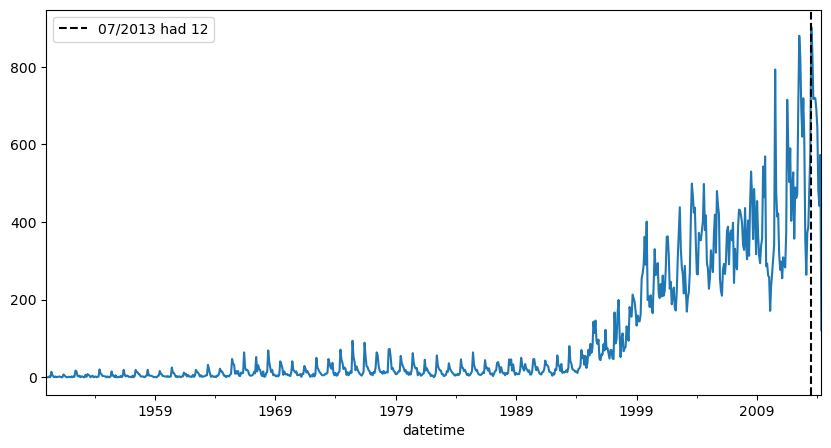

In [30]:
ax = m_ts.plot();
fmt = "%m/%Y"
ax.axvline(date_most_ufos, ls='--',color='k', 
           label=f"{date_most_ufos.strftime(fmt)} had {ts.loc[date_most_ufos]}")
ax.legend()

### 2) Which month of the year has the highest number of reported sightings?

In [31]:
## Check value counts of months
eda_df['month'].value_counts()

July         9520
August       8636
June         8152
September    7589
October      7407
November     6739
January      5689
December     5665
April        5527
March        5450
May          5293
February     4665
Name: month, dtype: int64


### 3) Is there a seasonal pattern to UFO sightings? If so, how long is the season?

### Seasonality

In [ ]:
import statsmodels.tsa.api as tsa

In [32]:
## Isolate just years since 2000 to capture recent trends
ts_check_season = m_ts.loc["2000":]
ts_check_season

datetime
2000-01-31    208
2000-02-29    181
2000-03-31    211
2000-04-30    180
2000-05-31    165
             ... 
2014-01-31    643
2014-02-28    481
2014-03-31    442
2014-04-30    573
2014-05-31    121
Freq: M, Length: 173, dtype: int64

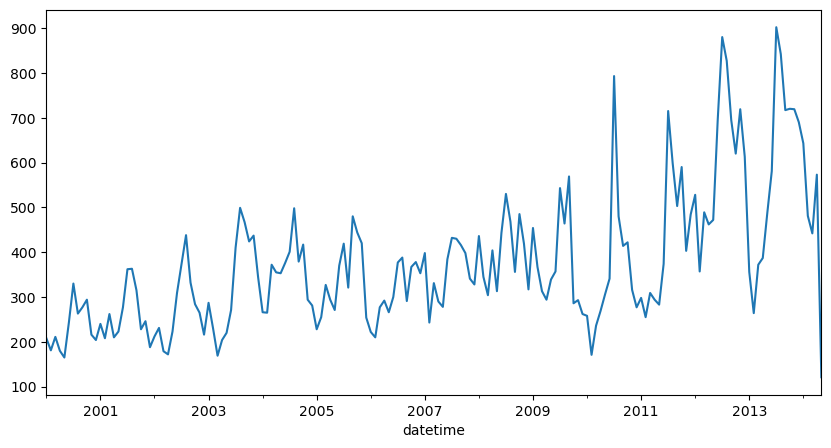

In [33]:
## plot the sliced ts
ts_check_season.plot();

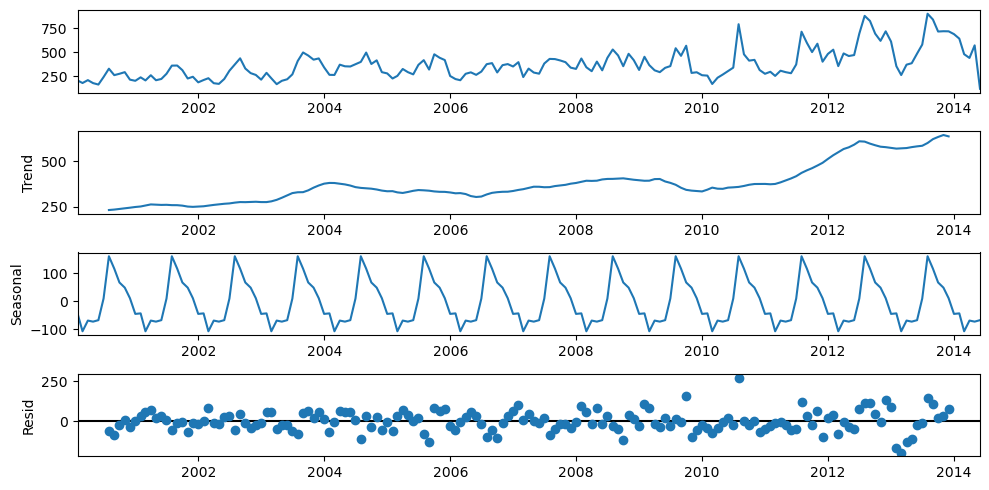

In [34]:
## Isolate trend and seasonal components with seasonal_decompose()
decomp = tsa.seasonal_decompose(ts_check_season)
decomp.plot();

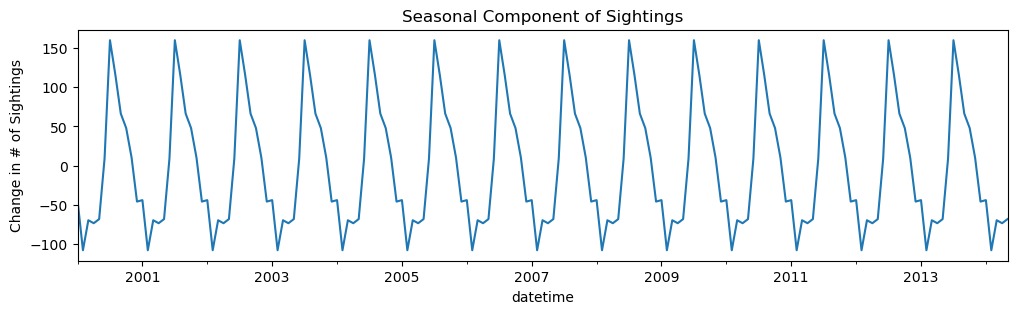

In [35]:
## separate seasonal component and plot
seasonal = decomp.seasonal
ax = seasonal.plot(figsize=(12,3))
ax.set(ylabel='Change in # of Sightings',
      title='Seasonal Component of Sightings');

### 4) Which US holiday has the largest number of sightings?

#### Feature Engineering: Holidays

In [37]:
# !pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

     ------------------------------------- 695.7/695.7 kB 11.1 MB/s eta 0:00:00


In [38]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [39]:
## create a test holiday 
test = "01/01/2015"
test

'01/01/2015'

In [40]:
## test the api 
us_holidays.get(test)

"New Year's Day"

In [41]:
## Saving both holiday types as columns
eda_df["US Holiday"] = eda_df['datetime'].map(us_holidays.get)
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend,decade,US Holiday
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,October,10,Monday,20,False,1940,None
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949,October,10,Monday,21,False,1940,None
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955,October,10,Monday,17,False,1950,None
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,October,10,Wednesday,21,False,1950,None
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,October,10,Monday,20,False,1960,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,2013,September,9,Monday,21,False,2010,None
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,2013,September,9,Monday,22,False,2010,None
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,2013,September,9,Monday,22,False,2010,None
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,2013,September,9,Monday,22,False,2010,None


In [42]:
eda_df['US Holiday'].unique()

array([None, 'Columbus Day', 'Veterans Day', 'Veterans Day (Observed)',
       "New Year's Day", 'Thanksgiving', 'Martin Luther King Jr. Day',
       "New Year's Day (Observed)", 'Christmas Day (Observed)',
       'Christmas Day', "Washington's Birthday", 'Memorial Day',
       'Independence Day (Observed)', 'Independence Day', 'Labor Day'],
      dtype=object)

#### Answer to which holiday has most sightings:

In [43]:
eda_df['US Holiday'].value_counts()

Independence Day               1208
New Year's Day                  676
Thanksgiving                    260
Christmas Day                   243
Columbus Day                    218
Veterans Day                    215
Labor Day                       198
Memorial Day                    168
Washington's Birthday           166
Martin Luther King Jr. Day      145
New Year's Day (Observed)        69
Veterans Day (Observed)          66
Independence Day (Observed)      62
Christmas Day (Observed)         52
Name: US Holiday, dtype: int64

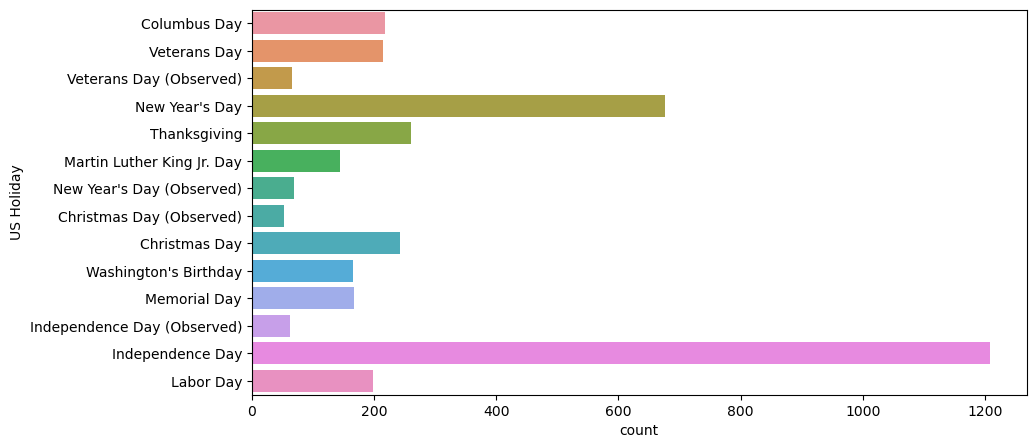

In [44]:
sns.countplot(data=eda_df, y='US Holiday');

#### Wait...when did that movie come out?

In [45]:
release_date= '1997-07-03'

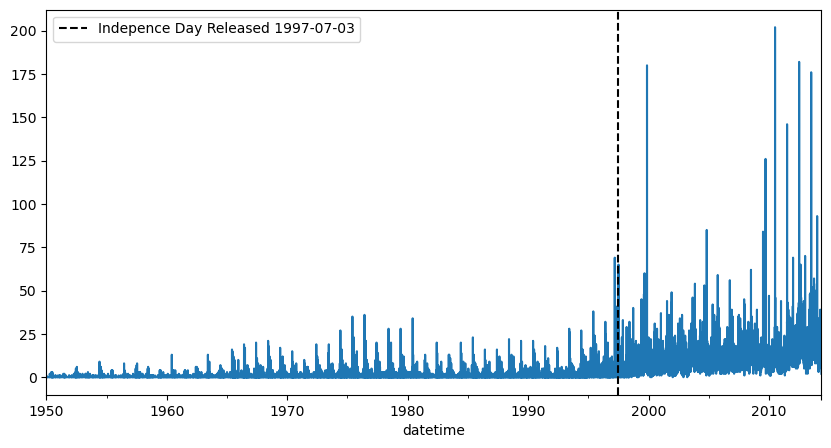

In [46]:
## Plot the # of sightings over time and annotate the release date
ax = ts.plot()
# rel_date = '1997-05-26'
ax.axvline(release_date, label=f'Indepence Day Released {release_date}',
          ls='--',color='k');
ax.legend();

## 🏓**Breakout Rooms: Answering Stakeholder Questions**

**Choose 1-2 of the remaining questions and work in breakout rooms to answer them:**
- 5) Which year had the highest % increase in sightings compared to previous years?
- 6) What day of the week has the highest reported sightings?
- 7) At what time of day (hour) do most sightings occur?
- 8) Which US state has the most sightings?
- 9) Which country had the largest proportion of sightings for the year 2000?
- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes



### 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

In [54]:
ts_a = m_ts.resample("A").sum().loc['1950':]
ts_a_pct_change = ts_a.pct_change()

In [55]:
biggest_change = ts_a_pct_change.abs().idxmax()
biggest_change

Timestamp('1995-12-31 00:00:00', freq='A-DEC')

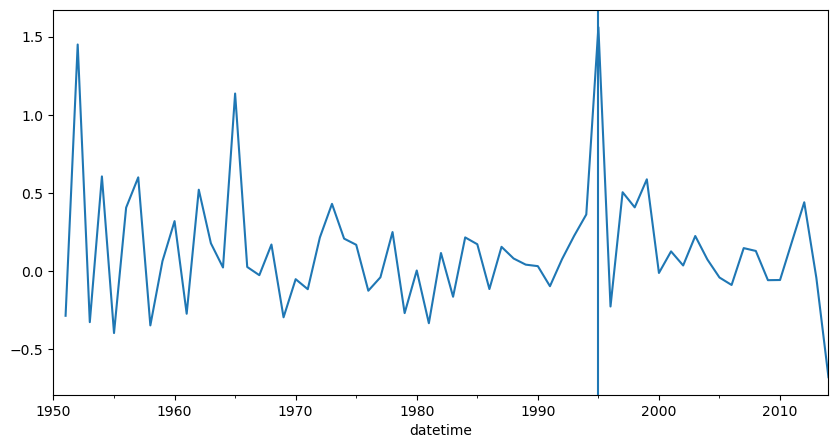

In [57]:
ax = ts_a_pct_change.plot();
ax.axvline(biggest_change)

### 6) What day of the week has the highest reported sightings?

In [ ]:
eda_df['day of week'].value_counts(1)

### 7) At what time of day (hour) do most sightings occur?

In [ ]:
eda_df['hour'].value_counts()

### 8) Which US state has the most sightings?

In [ ]:
eda_ts['state'].value_counts()

### 9) Which country had the largest proportion of sightings for the year 2000?

In [ ]:
eda_ts.loc['2000','country'].value_counts()

### 10) Have the types/shapes of UFO's witness changed over time?

In [ ]:
eda_ts['shape'].value_counts(1)

In [ ]:
## keep only shapes that are at least 
use_shapes = eda_ts['shape'].value_counts(1).head(4).index
use_shapes

In [ ]:
ts_shapes = eda_ts.groupby('shape').resample("A").size()
ts_shapes

In [ ]:
## keeping only most common
ts_shapes = ts_shapes.unstack(0).fillna(0)[use_shapes]
ts_shapes

In [ ]:
ts_shapes = ts_shapes.loc['1980':]

In [ ]:
ts_shapes.plot()

In [ ]:
# ts_shapes.pct_change().plot()

# Bonus: Plotly Express

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.templates

### Map Over Time

In [ ]:
eda_df = eda_df.sort_values('decade')

In [ ]:
# let's use coerce - 1 row is fine to lose
eda_df['latitude'] = pd.to_numeric(eda_df['latitude'], errors='coerce')
eda_df

In [ ]:
try:
    px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade")
except Exception as e:
    display(e)

In [ ]:
eda_df.columns = eda_df.columns.str.strip()
eda_df

In [ ]:
px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade",
              template='ggplot2')